# Расчет  двухфазного потока через штуцер:
### 1. Расчет расхода в зависимости от давления на выходе, при разных давлениях на входе
### 2. Расчет давления на входе в зависимости от расхода, при разных давлениях на выходе
### 3. Расчет давления на выходе в зависимости от расхода, при разных давлениях на входе
### 4. Расчет перепада давления в зависимости от расхода  при фиксированном давлении на входе

###    

Расчеты ведутся на основе методики E.M.Al-Safran (Kuwait University) и M.Kelkar (The University of Tulsa)

статья SPE: Predictions of Two-Phase Critical-Flow Boundary and Mass-Flow Rate Across Chokes

https://www.onepetro.org/journal-paper/SPE-109243-PA

В отличии от методик, используемых в настоящее время,  модель учитывает проскальзывание между жидкой и газовой фазами при прохождении через штуцер. Прогнозирует границу перехода с докритического на критический режим, учитывая эффект проскальзывания.

В статье указано, что давление должно быть в Па, изменил на кПа. с Па получались слишком большие значения расхода.

###    

#### Модель имеет следующие ограничения:

- Отношение диаметра штуцера к диаметру трубы в четвертой степени приравнивается к нулю 

### $ (\frac{d_{choke}}{d_{pipe}})^4=0 $

- Сухость насыщенного пара считается потоянной


- Жидкая фаза несжимаема


- Газовая фаза расширяется политропически (удельная теплоемкость газа остается постоянной)


In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sympy import *
import scipy.optimize as opt
import logging
from pyXSteam.XSteam import XSteam
steamTable = XSteam(XSteam.UNIT_SYSTEM_MKS)

In [2]:
def qmix_choke_kghr(p1_atm, p2_atm, dchoke_mm=5):
    """
    расчет дебита ГЖС через штуцер по методике Альсафран 
    p1_atm - давление на входе в штуцер, атм
    p2_atm - давление на выходе из штуцера, атм
    dchoke_mm - диаметр штуцера,мм
    """
    Cd=0.75 # дисчарч коэффициент для штуцера (коэффициент разряда штуцера)
    g_c=9.8 # ускорение свободного падения
    p1_pa=p1_atm*100 # давление до штуцера, Па
    p2_pa=p2_atm*100 # давление после штуцера, Па
    Vg1=steamTable.vV_p(p1_atm)  # удельный объем пара, м3/кг
    Vl=steamTable.vL_p(p1_atm)  # удельный объем жидкости, м3/кг
    CL=steamTable.CvL_p(p1_atm)  # удельная теплоемкость жидкости, кДж/кг/К
    Cvg=steamTable.CvV_p(p1_atm)  # удельная теплоемкость пара при постоянном объеме, кДж/кг/К 
    Cpg=steamTable.CpV_p(p1_atm)  # удельная теплоемкость пара при постоянном давлении, кДж/кг/К 
    k=Cpg/Cvg # показатель адиабаты
    d2=dchoke_mm/1000 #диаметр клапана, м
    xg=1 #  массовая доля пара
    R=(1+xg*(Vg1/Vl-1))**0.5*(1+0.6/2.718**(5*xg))
    alfa=R*(1-xg)*Vl/(xg*Vg1)
    A2=3.14*d2**2/4
    n=(xg*k*Cvg+(1-xg)*CL)/(xg*Cvg+(1-xg)*CL)
    def y(x):
        y=(alfa*(1-x)+n/(n-1))/(n/(n-1)+n/2*(1+alfa*x**(1/n))**2)-x**(1-1/n)
        return(y)
    rc = opt.fsolve(y, 0.5)
    r=p2_pa/p1_pa
    if rc >= r: pr=rc
    else: pr=r
    if pr>1: pr=1
    Ab=n/(n-1)*(1-pr**((n-1)/n))+alfa*(1-pr)
    Ac=xg*Vg1*(pr**(-1/n)+alfa)**2*(xg+1/R*(1-xg))
    wi=A2*(288*g_c*Cd**2*p1_pa*Ab/Ac)**0.5*3600
    return wi

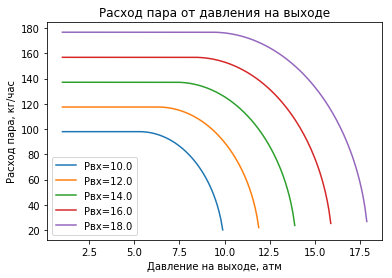

In [3]:
'Построение графика "Расход пара от давления на выходе"'
p1_atm_a= np.arange(10,20,2) #давление на входе для которых расчитывается расход, в зависимости от давления на выходе, атм
for p1_atm in p1_atm_a:
    p2_a=np.arange(1,p1_atm,0.1)
    q=np.array([])
    for p2 in p2_a:
        p1=qmix_choke_kghr(p1_atm, p2,5)
        q=np.append(q,p1)
    plt.plot(p2_a,q,label='Рвх=%1.1f'%p1_atm) 
plt.title('Расход пара от давления на выходе')
plt.ylabel('Расход пара, кг/час')
plt.xlabel('Давление на выходе, атм')
plt.legend()
plt.show()

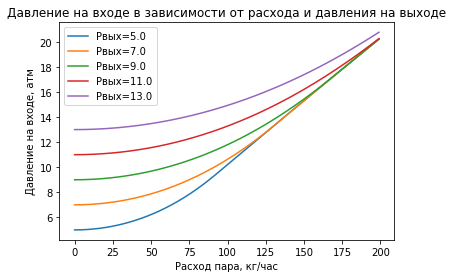

In [4]:
'Построение графика "Давление на входе в зависимости от расхода и давления на выходе"'
'Давление на входе считается с помощью функции opt.fsolve '
p2_atm_a= np.arange(5,15,2)  #давление на выходе для которых расчитываются давления на входе в зависимости от расхода, атм
for p2_atm in p2_atm_a:
    i_a=np.arange(0,200,1) # расход, кг/час для которого находится давление на входе
    for i in i_a:
        def w2(p1_atm):
            return qmix_choke_kghr(p1_atm,p2_atm)-i
        def p1_atm(w2):
            p1_atm=opt.fsolve(w2,p2_atm)
            return p1_atm
    q=np.array([])
    for i in i_a:
        p1=p1_atm(w2)
        q=np.append(q,p1)
    plt.plot(i_a,q,label='Рвых=%1.1f'%p2_atm)
plt.title('Давление на входе в зависимости от расхода и давления на выходе')
plt.xlabel('Расход пара, кг/час')
plt.ylabel('Давление на входе, атм')   
plt.legend()
plt.show() 

C:\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


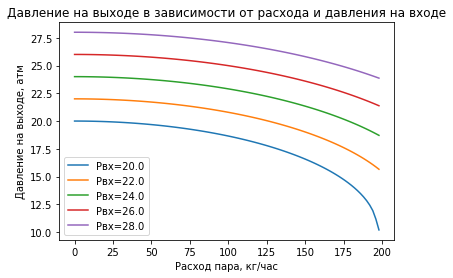

In [5]:
'Построение графика "Давление на выходе в зависимости от расхода и давления на входе"'
'Давление на выходе считается с помощью функции opt.fsolve '
p1_atm_a= np.arange(20,30,2)  #давление на входе для которых расчитываются давления на выходе в зависимости от расхода, атм
for p1_atm in p1_atm_a:
    i_a=np.arange(0,200,2) # расход, кг/час для которого находится давление на выходе
    for i in i_a:
        def w2(p2_atm):
            return qmix_choke_kghr(p1_atm,p2_atm)-i
        def p2_atm(w2):
            p2_atm=opt.fsolve(w2,p1_atm-0.00001)
            return p2_atm
    q=np.array([])
    for i in i_a:
        p2=p2_atm(w2)
        q=np.append(q,p2)
    plt.plot(i_a,q,label='Рвх=%1.1f'%p1_atm)
plt.title('Давление на выходе в зависимости от расхода и давления на входе')
plt.xlabel('Расход пара, кг/час')
plt.ylabel('Давление на выходе, атм')   
plt.legend()
plt.show()  

C:\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


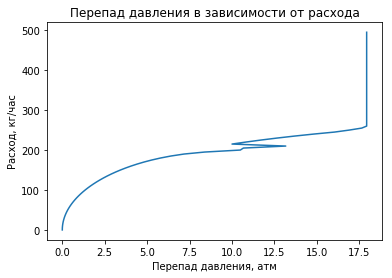

In [7]:
'Построение графика "Перепад давления в зависимости от расхода"'
'Разница давлений считается с помощью функции opt.fsolve '
i_a=np.arange(0,500,5) # расход, кг/час для которого находится перепад давлений
p1_atm=20 # фиксированное давление на входе, атм
for i in i_a:
    def w2(f):
        return qmix_choke_kghr(p1_atm,p1_atm-f)-i
    def f(w2):
        f=opt.fsolve(w2,0)
        return f
    q=np.array([])
    for i in i_a:
        f1=f(w2)
        q=np.append(q,f1)
plt.plot(q, i_a)
plt.title('Перепад давления в зависимости от расхода')
plt.ylabel('Расход, кг/час')
plt.xlabel('Перепад давления, атм')   
plt.show() 